<h1>Data Processing</h1>

Ziel dieses Notebooks ist, die gescrapeten Daten so zu verarbeiten, dass Sie später thematisch durchsucht werden können. Ein Embeddingvektor liefert genau diese Funktion. Auf eine Anfrage hin wird der Abstand zwischen dem Embedding der Frage und den Embeddings aller anderen Dokumenten berechnet. Dann werden die Dokumente mit den kleinsten Abständen ausgewählt und dem LLM als Kontext mitgegeben. Mithilfe des Wissens dieser Dokumente soll dass LLM dann in der Lage sein die Frage korrekt zu beantworten.
Für die Embeddings benutzen wir [Google Bert](https://blog.google/products/search/search-language-understanding-bert/)

Beispiel:

User: Welche Dozenten unterrichten das Fach Grundlagen der Informatik?

System wählt besten 5 Dokumente aus 

    <Dokument 1>: ... betreute Prof. Dr. Löhr eine Batchelorarbeit in Grundlagen der Informatik...
    <Dokument 2>: Prof. Dr. Weber tel.: 013882664 email: weber@th.de Raum: HQ: 403, Fächer: Grundlagen der Informatik ...
    <Dokument 3> ...
    <Dokument 4> ...
    <Dokument 5> ...
    

Aus der Nutzeranfrage und den Dokumenten wird eine neue Query erstellt, die dem LLM dann final bereitgetellt wird. Diese sieht in etwa so aus:

    
    <Dokument 1>: ... betreute Prof. Dr. Löhr eine Batchelorarbeit in Grundlagen der     Informatik...
    <Dokument 2>: Prof. Dr. Weber tel.: 013882664 email: weber@th.de Raum: HQ: 403, Fächer: Grundlagen der Informatik ...
    <Dokument 3> ...
    <Dokument 4> ...
    <Dokument 5> ...

    Bitte beantworte folgende Frage unter der Berücksichtigung obiger Dokumente:
    Welche Dozenten unterrichten das Fach Grundlagen der Informatik?


Das LLM wird daraufhin hoffentlich korrekt eine Antwort liefern die ähnlich ist zu:

    A: An der TH Nürnberg Georg Simon Ohm unterichten die Professoren Prof. Dr. Löhr und Prof. Dr. Weber das Fach Grundlagen der Informatik.


In [45]:
import ast
from db_init import db_get_df, db_save_df
import json
# import gensim
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd
import random
from question_embedding import question_embeddings
from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE 
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import torch
from transformers import BertModel, BertTokenizer
from tqdm import tqdm
from wordcloud import WordCloud

Zunächst laden wir die Daten aus der Datenbank. Dabei besitzt jedes Dokument als Metadaten den Titel der Webseite, den filenamen und den Text. Diese speichern wir uns in einen Pandas Dataframe

In [ ]:
df = db_get_df("html_attrs", ["filename", "title", "text"])

print(df.dtypes)
print(df["text"][3])

Zur überprüfung der Texte können wir nun einmal eine Keywordsuche starten. Dieser Ansatz wird außerdem tiefer im Notebook [spacy_keywordextraction](./spacy_keywordextraction.ipynb) verfolgt.

In [ ]:
word = "Gallwitz"

[text for text in df["text"] if word in text][:5]

Jetzt werden wir für jedes Dokument ein eigenes Word embeddings erstellen. Dazu müssen wir zunächst das BERT Model laden.
Das BERT Model ist ein von Google trainiertes mehrschichtiges neuronales Netz, welches ursprünglich dafür entwickelt wurde, dass ???
es ist trainiert auf 10.000+ Büchern
es gibt Modelle "base" und "large"
uncased heißt ohne klein - Großschreibung

Wir brauchen zur vorbereitung die zusätzlichen Token
[SEP] um das Ende eines Satzes zu markieren
[CLS] am Anfang des Texten
[PAD] zum auffüllen der Token 
Außerdem
TokenIDs
MaskIDs - zum filtern der [PAD]
Segment IDs um verschiedene Sätze zu unterscheiden
Posititional Embeddings


In [46]:
#TODO try better model
# BertModel.from_pretrained('bert-base-german-cased',output_hidden_states = True) 
model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True) 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
testSentence = "In der Bibliothek gibt es 40 Bücher zum Thema Animes"
tokens_question = tokenizer.tokenize(testSentence)
print(*tokens_question)

Nun erstellen wir eine neue Spalte ["tokens"], in der wir für jedes Dokument die Tokens abspeichern.

In [ ]:
df["tokens"] = [tokenizer.tokenize(text) for text in tqdm(df["text"])]

Der dataframe hat nun eine Spalte mehr und wir können uns ein Beispiel der Tokens ansehen.

In [ ]:
print(df.dtypes)
print(df["tokens"][2])

Diese Tokens müssen nun in IDs umgewandelt werden, damit sie das BERT Model für die erstellung eines Embedding Vectors benutzen kann. Dafür benutzen wir eine Funktion des Tokenizers convert_tokens_to_id.

In [ ]:
df["token_ids"] = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tqdm(df["tokens"])]

In [47]:
special_symbols = ["[CLS]", "[SEP]", "[PAD]"]
print(tokenizer.convert_tokens_to_ids(special_symbols))


[101, 102, 0]


Wir haben jetzt also die Tokens IDs für unsere 2400 verschiedenen Dokumente gebildet. Der nächste Schritt wäre nun, diese Tokens IDs in dem BERT Model zu übergeben, sodass es uns ein Embedding daraus errechnet. Leider kann das BERT Model nur 512 Tokens (~1300 Zeichen) als Input nehmen. Die meißten der gescrapeten Webseiten sind aber wesentlich länger. Der Naheliegendste Ansatz ist dabei, die Tokens einfach in 510 token große Chunks aufzusplitten (Wir brauchen noch 2 Tokens extra für jeden Chunk) und für jeden Chunk ein extra Embedding zu erstellen. Dabei gibt es entweder die Möglichkeit die Chunks überlappend, oder einfach hard cut zu gestalten. Wir werden hier zunächst den hard cut Ansatz verfolgen. 

In [ ]:
# splice dokuments in 512 token chunks

# Initialize an empty list to store rows for the new DataFrame
new_rows = []

# Function to split text and tokens into chunks of 512 tokens
def split_text_and_tokens(row):
    text = row['text']
    tokens_ids = row['token_ids']
    filename = row['filename']

    if len(tokens_ids) > 510:
        # Split into multiple chunks
        for i in range(0, len(tokens_ids), 510):
            chunk_tokens = tokens_ids[i:i + 510]
            # adding the [CLS] and the [SEP] token
            chunk_tokens = [101] + chunk_tokens + [102]
            chunk_text = tokenizer.decode(chunk_tokens)

            # Create a new row with a reference to the original row
            new_row = {'filename': filename, 'chunk_id': i/510, 'chunk_text': chunk_text, 'chunk_tokens_json': json.dumps(chunk_tokens)}
            new_rows.append(new_row)
    else:
        # If the row has 510 tokens or fewer, keep it as is

        # adding the [CLS] and the [SEP] token
        tokens_ids = [101] + tokens_ids + [102]
        tokens_ids = tokens_ids + [0] * (512 -len(tokens_ids))
        text = "[CLS]" + text + "[SEP]"
        new_row = {'filename': filename, 'chunk_id': 0, 'chunk_text': text, 'chunk_tokens_json': json.dumps(tokens_ids) }
        new_rows.append(new_row)

df.apply(split_text_and_tokens, axis=1)

# Create a new DataFrame from the list of new rows
chunk_df = pd.DataFrame(new_rows)

# Reset the index of the new DataFrame if needed
chunk_df.reset_index(drop=True, inplace=True)

# Print the new DataFrame
print(chunk_df.sample(2).to_markdown())

# tokenizer.convert_tokens_to_string


Ab jetzt werden wir mit dem neuen chunk_df weiterarbeiten. Nun erstellen wir für jeden Chunk ein eigenes Embedding, welches dann die Semantik dieses chunks enthalten soll. Dafür müssen wir uns nun das BERT Model etwas genauer anschauen.

In [ ]:
def proccessSentence(tokens, model, tokenizer):
    if len(tokens) == 0:
        # Handle the case when the token list is empty, for example, return a default embedding or raise an exception.
        # For demonstration purposes, we'll return a zero tensor as the default embedding.
        return torch.zeros(768)

    tokens = ["CLS"] + tokens + ["SEP"]

    attention_mask = [1 if token != "[PAD]" else 0  for token in tokens]
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    token_ids_tensor = torch.tensor([token_ids], dtype=torch.int64)
    attetion_mask_tensor = torch.tensor([attention_mask], dtype=torch.int64)

    with torch.no_grad():
        outputs = model(token_ids_tensor, attetion_mask_tensor)
        hidden_states = outputs[2]

    # stack the layer list 
    token_embeddings = torch.stack(hidden_states, dim=0)
    # remove the batches dim
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    # Swap dimensions 0 and 1.
    token_embeddings = token_embeddings.permute(1,0,2)
    # average all token embeds
    layer_vecs = torch.mean(token_embeddings, dim=0)



    # Calculate the average of layer 3 to 13
    embed = torch.mean(layer_vecs[2:], dim=0)


    return embed


df["chunk_embeddings"] = [proccessSentence(tokens).tolist() for tokens in tqdm(df["tokens"])]


Diser Code kann sehr lange brauchen um die Embeddings zu berechnen. An dieser Stelle sollte man dann die Embeddings am besten abspeichern. 

db_save_df(df, "chunk_embeddings")

In [33]:
df = db_get_df("chunk_embeddings", ["*"])

In [36]:

def embed_t_sne(embed_id):
    df_embed=[json.loads(embedding) for embedding in tqdm(df[f"chunk_embeddings_{embed_id}"])]
    word_embeddings = np.array(df_embed)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    X_embedded = tsne.fit_transform(word_embeddings)


    plt.figure(figsize=(10, 6))
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=5)
    plt.title(f"t-SNE Visualization of Word Embeddings {embed_id}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show() 

  0%|          | 0/7765 [00:00<?, ?it/s]

100%|██████████| 7765/7765 [00:03<00:00, 2494.26it/s]


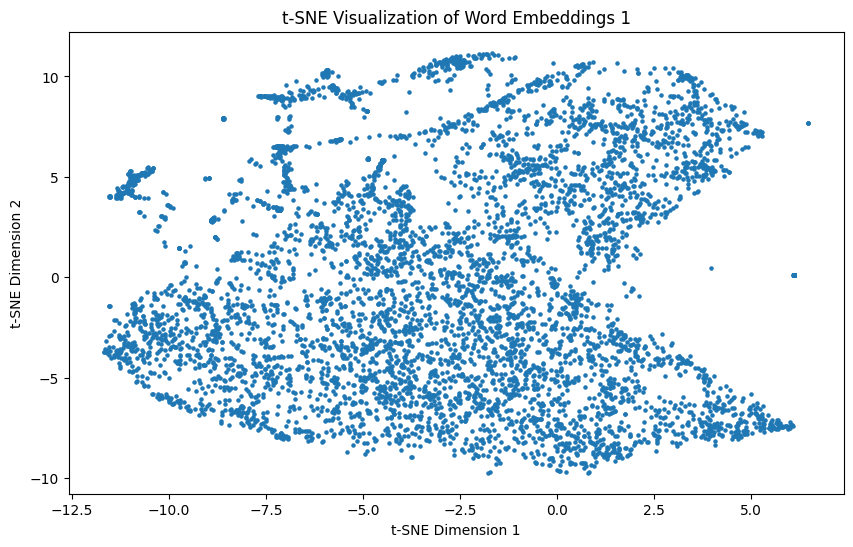

100%|██████████| 7765/7765 [00:02<00:00, 2624.52it/s]


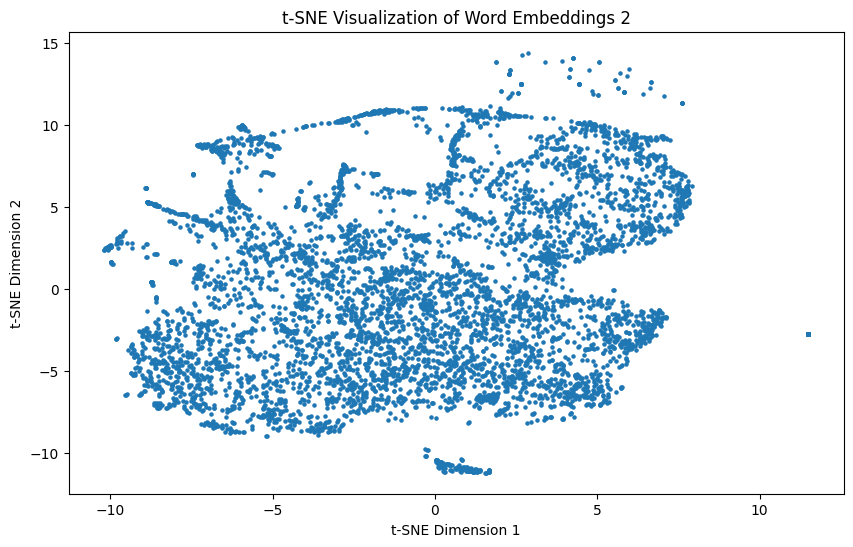

100%|██████████| 7765/7765 [00:02<00:00, 2595.36it/s]


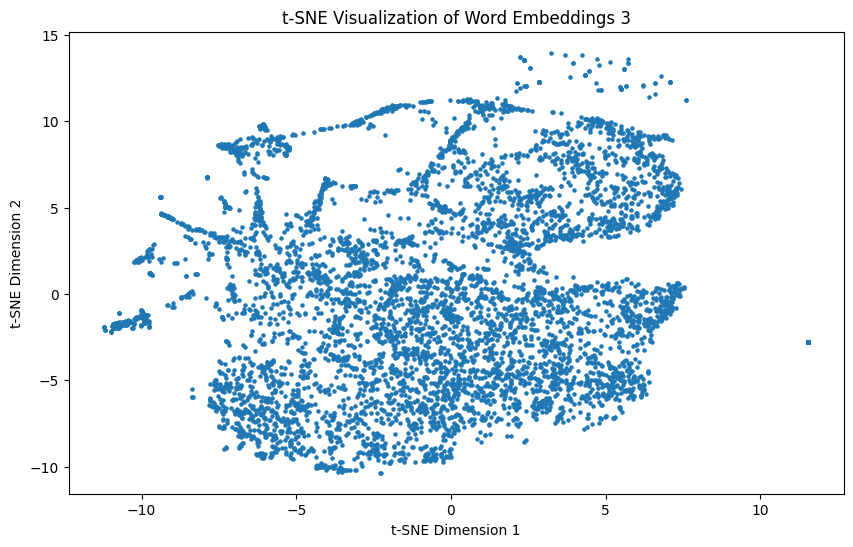

100%|██████████| 7765/7765 [00:02<00:00, 2638.53it/s]


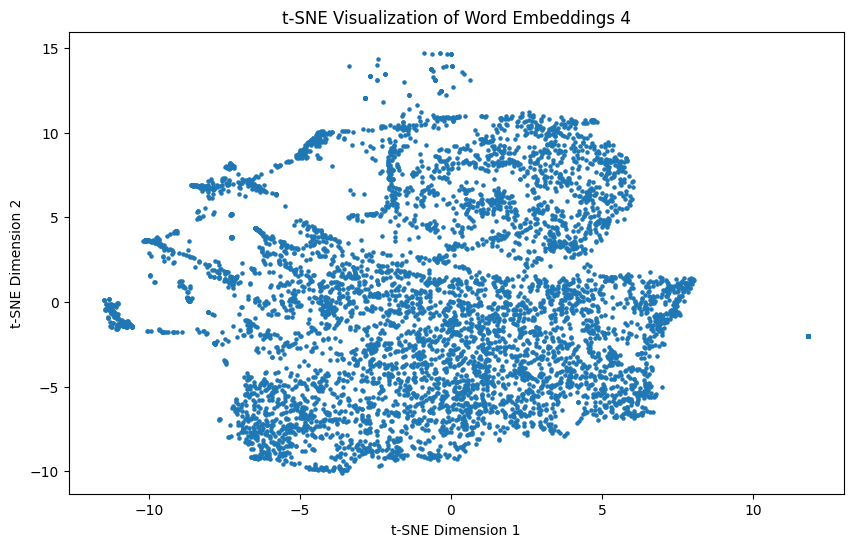

100%|██████████| 7765/7765 [00:13<00:00, 574.87it/s]


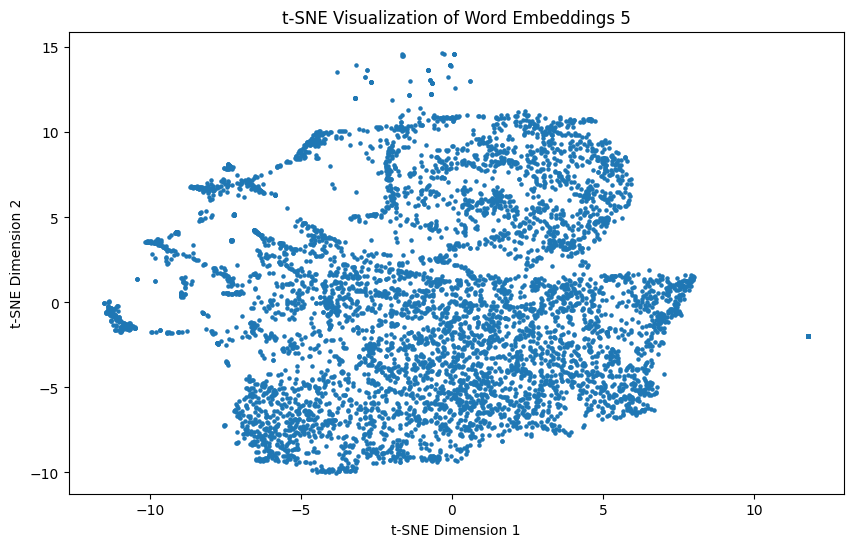

In [38]:
for i in range(5):
    embed_t_sne(i +1)

100%|██████████| 7765/7765 [00:04<00:00, 1604.31it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


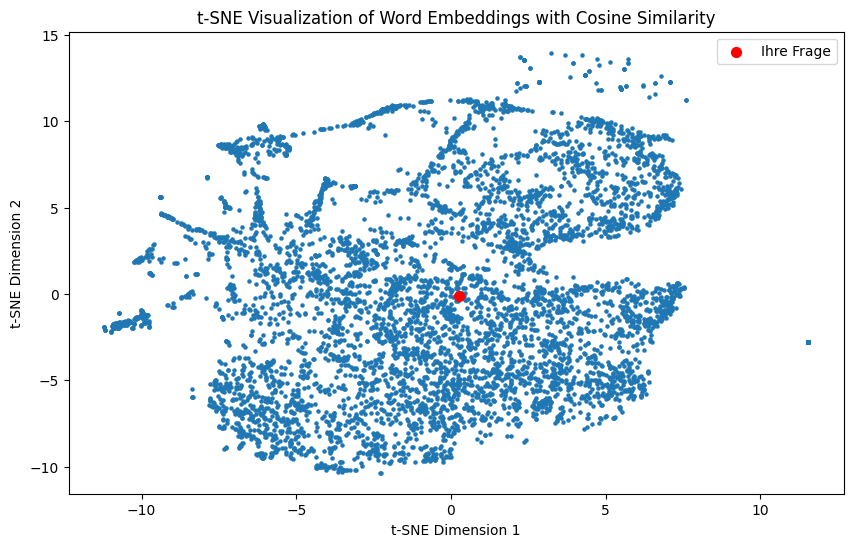

In [39]:
# Funktion zur Extraktion von Word Embeddings für die Frage
def get_word_embedding(question, model_name='bert-base-uncased'):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)

    tokens = tokenizer(question, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
        question_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return question_embedding

# Laden der Word Embeddings
df = db_get_df("chunk_embeddings", ["chunk_embeddings_2"])
df = [json.loads(embedding) for embedding in tqdm(df["chunk_embeddings_2"])]
word_embeddings = np.array(df)

# Extrahieren der Embeddings für die Frage
question_text = "n?"
question_embedding = get_word_embedding(question_text)

# Berechnen der Kosinus-Ähnlichkeit zwischen der Frage und den anderen Word Embeddings
similarities = cosine_similarity(word_embeddings, [question_embedding])

# 'similarities' ist jetzt ein Array mit den Kosinus-Ähnlichkeiten zwischen der Frage und den anderen Word Embeddings.

# Kombinieren Sie die t-SNE-Komponenten mit den Kosinus-Ähnlichkeiten
combined_features = np.column_stack((X_embedded, similarities))

# Visualisierung
plt.figure(figsize=(10, 6))
plt.scatter(combined_features[:, 0], combined_features[:, 1], s=5)
plt.scatter(question_embedding[0], question_embedding[1], color='red', s=50, label='Ihre Frage')
plt.title("t-SNE Visualization of Word Embeddings with Cosine Similarity")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()


/Users/br/Projects/IT-Ptojekt-Chatbot/daibl/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect 

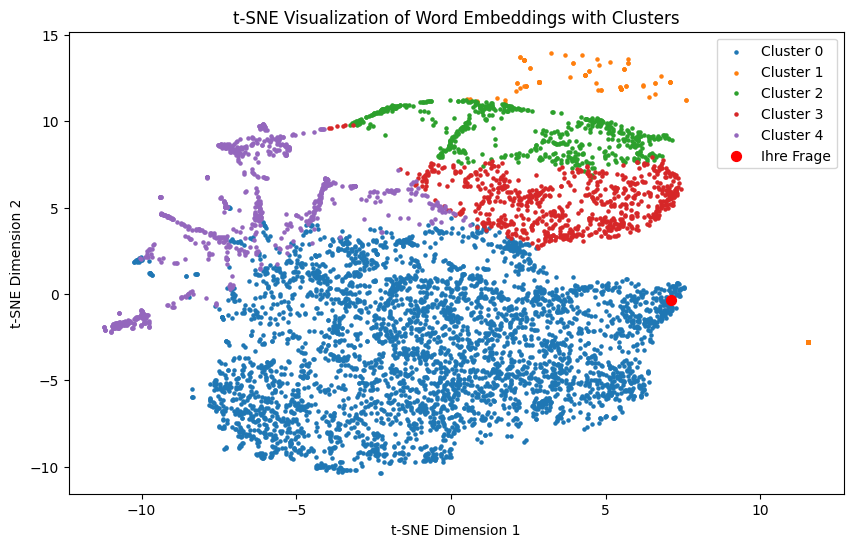

In [40]:
# Annahme: X_embedded ist Ihre t-SNE-Visualisierung
# Annahme: word_embeddings ist Ihre Matrix der Word Embeddings
# Annahme: question_text ist Ihre Frage
# Annahme: n_clusters ist die Anzahl der gewünschten Cluster
question_text = "Welche Kompetenzen hat Pr. Gallwitz?" #wann ist der Bewerbungszeitraum  Für das Wintersemester

# Schritt 1: Clustering durchführen
kmeans = KMeans(n_clusters=5, random_state=0)
cluster_labels = kmeans.fit_predict(word_embeddings)

# Schritt 3: Berechnen der Ähnlichkeit zur Frage
question_embedding = get_word_embedding(question_text)  # Verwenden Sie Ihre get_word_embedding Funktion
similarities = cosine_similarity(word_embeddings, [question_embedding])

# Schritt 4: Visualisierung aktualisieren
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.scatter(X_embedded[cluster_labels == i, 0], X_embedded[cluster_labels == i, 1], s=5, label=f'Cluster {i}')

# Farben entsprechend des Clusters für die Frage aktualisieren
question_cluster = np.argmax(similarities)
plt.scatter(X_embedded[question_cluster, 0], X_embedded[question_cluster, 1], s=50, color='red', label='Ihre Frage')

plt.title("t-SNE Visualization of Word Embeddings with Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()


In [ ]:

kmeans = KMeans(n_clusters=5)  # Specify the number of clusters you want
cluster_labels = kmeans.fit_predict(word_embeddings)


In [ ]:
plt.figure(figsize=(10, 6))
for i in range(len(np.unique(cluster_labels))):
    plt.scatter(X_embedded[cluster_labels == i, 0], X_embedded[cluster_labels == i, 1], s=5, label=f'Cluster {i}')

plt.title("t-SNE Visualization of Word Embeddings with Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

In [ ]:
# Filter the indices of data points in Cluster 0
cluster0_indices = np.where(cluster_labels == 1)

# Get the corresponding rows from the DataFrame 'df'
cluster0_data_rows = df.iloc[cluster0_indices]

# Print the 'text' column for the data points in Cluster 0
for text in cluster0_data_rows['text']:
    print(text)


In [ ]:


# Annahme: Ihr DataFrame 'df' enthält eine Spalte 'text' mit den Textdaten.

# Anzahl der Cluster (angenommen, es sind 5 Cluster)
num_clusters = 5

for cluster_id in range(num_clusters):
    # Filtern Sie die Zeilen für den aktuellen Cluster
    cluster_data_rows = df

    # Laden des spaCy-Modells für die Textverarbeitung
    nlp = spacy.load("de_core_news_sm")

    # Benutzerdefinierte Stoppwortliste
    stopwords = {'www', 'th-nuernberg', 'nürnberg', 'nuernberg', 'th', 'technische', 'hochschule', 'ohm', 'de', 'punkt', 'simon'}

    # Tokenisieren und Lemmatisieren der Texte, Entfernen der Stoppwörter und Konvertieren in Strings
    processed_texts = []
    for text in cluster_data_rows['text']:
        doc = nlp(text)
        processed_tokens = []
        for token in doc:
            if token.text.lower() not in stopwords and token.pos_ in {'NOUN', 'PROPN'}:
                processed_tokens.append(token.text)
        processed_texts.append(' '.join(processed_tokens))

    # Erstellen eines Wörterbuchs und einer Textkorpus für das LDA-Modell
    text_tokens = [text.split() for text in processed_texts]
    dictionary = gensim.corpora.Dictionary(text_tokens)
    corpus = [dictionary.doc2bow(tokens) for tokens in text_tokens]

    # Anwendung des LDA-Modells
    lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

    # Anzeigen der Hauptthemen für den aktuellen Cluster
    print(f"Cluster {cluster_id} Topics:")
    for topic_id, topic in lda_model.print_topics():
        print(f"Topic {topic_id}: {topic}")
    print("\n")


In [ ]:


all_text = ' '.join(processed_texts)  # 'processed_texts' ist die Liste der bereinigten Texte

# Erstellen der Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Anzeigen der Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

In [ ]:


# Erstellen einer Liste von Stoppwörtern, einschließlich der URL und der benutzerdefinierten Wörter
stopwords = set(['www', 'th-nuernberg', 'nürnberg', 'nuernberg', 'th', 'technische', 'hochschule', 'ohm', 'de', 'punkt', 'simon','https','http','nuremberg','telefon','email','fax','Prof Dr','studium'])
stopwords = set(word.lower() for word in stopwords)  # In Kleinbuchstaben umwandeln

# Anzahl der Cluster (angenommen, es sind 5 Cluster)
num_clusters = 5

for cluster_id in range(num_clusters):
    if cluster_id == 0:
        continue
    # Filter the indices of data points in the current cluster
    cluster_indices = np.where(cluster_labels == cluster_id)

    # Get the corresponding rows from the DataFrame 'df'
    cluster_data_rows = df.iloc[cluster_indices]

    # Extract and preprocess text data
    texts = cluster_data_rows['text']
    nlp = spacy.load("de_core_news_sm")
    processed_texts = [' '.join([token.text for token in nlp(text) if not token.is_stop and token.text.lower() not in stopwords]) for text in texts]

    # Create a Word Cloud for the current cluster
    all_text = ' '.join(processed_texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

    # Display the Word Cloud for the current cluster
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Cluster {cluster_id}")
    plt.show()


import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
question="Welche Kompetenzen hat Prf. Gallwitz?"
# Assume you have a DataFrame df with a 'text' column that contains your documents
# Also, assume you have a 'question' string for which you want to find relevant documents.

# Create a TF-IDF vectorizer with the same parameters as before
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on your documents
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

# Transform the question string into TF-IDF representation
question_tfidf = tfidf_vectorizer.transform([question])

# Calculate cosine similarities between the question and all documents
similarities = cosine_similarity(question_tfidf, tfidf_matrix)

# Create a DataFrame to store similarities and document texts
similarity_df = pd.DataFrame({
    'Similarity': similarities[0],
    'Text': df['text']
})

# Sort the DataFrame by similarity in descending order
sorted_similarity_df = similarity_df.sort_values(by='Similarity', ascending=False)

# Print the top N most relevant documents (e.g., top 5)
top_n = 5
relevant_documents = sorted_similarity_df.head(top_n)

# Print the relevant documents and their similarities to the question
for index, row in relevant_documents.iterrows():
    print(f"Similarity: {row['Similarity']}")
    print(row['Text'])
    print('-' * 50)


In [ ]:
# database = 'discord_bot/scrap/html.sqlite'

# with sqlite3.connect(database) as con:
#     html_df.to_sql('html_with_embeddings', con, index=False, if_exists='replace')

In [ ]:
#dokument--> bert anwenden für jeden dokument
# question-bert anwenden
question="was macht Gallwitz?"
document=df["text"][1]

tokens_question = tokenizer.tokenize(question)
tokens_document = tokenizer.tokenize(document)
attetion_mask_question = [1] * len(tokens_question)
attention_mask_dokument = [1] * len(tokens_document)

token_idss = tokenizer.convert_tokens_to_ids(tokens_question)
tokenDocument_idss = tokenizer.convert_tokens_to_ids(tokens_document)


tokens_tensor = torch.tensor([token_idss])
segments_tensors = torch.tensor([attetion_mask_question])

tokensDocument_tensor = torch.tensor([tokenDocument_idss])
segmentsDocument_tensors = torch.tensor([attention_mask_dokument])

with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

with torch.no_grad():
    outputs = model(tokensDocument_tensor, segmentsDocument_tensors)
    hiddenDocuments_states = outputs[2]

# print(token_idss)
# print(tokenDocument_idss)

print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))


In [ ]:
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings = token_embeddings.permute(1,0,2)

token_vecs_sum = []

# For each token in the sentence...
for token in token_embeddings:
    
    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

In [ ]:
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)
print ("Our final sentence embedding vector of shape:", sentence_embedding)


tokenDocuments_vecs = hiddenDocuments_states[-2][0]

# Calculate the average of all 22 token vectors.
sentenceDocument_embedding = torch.mean(tokenDocuments_vecs, dim=0)
print ("Our final sentence embedding vector of shape:", sentence_embedding)


In [ ]:
# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(sentence_embedding, sentenceDocument_embedding)

print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

In [ ]:
word = "Fachhochschulgesetz"

df.loc[df["text"].str.contains(word)]["text"]
# [text for text in df["text"] if word in text][:5]

Was besagt das Fachhochschulgesetz?
|      | chunk_text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

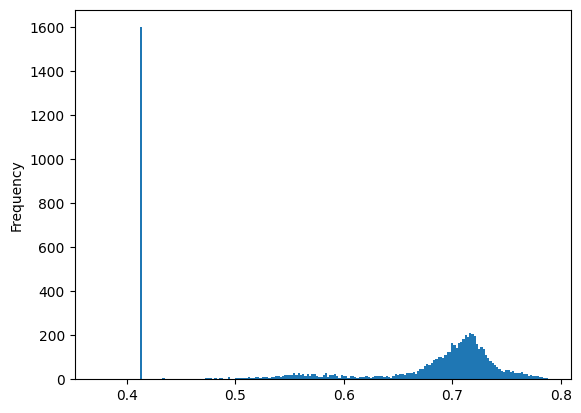

In [42]:
df = db_get_df("chunk_embeddings")
questions = ["Was besagt das Fachhochschulgesetz?", 
             "Wo befindet sich die Mensa", 
             "Welche Professoren gibt es an der Technischen Hochschule Nürnberg?",
             "Gib mir alle Infos zum Studienstart",
             "Was gibt es Neues im Bezug auf Künstliche Intelligenz an der Hochschule?",
             "Themen für eine Batchelorarbeit",
             "Where is the Language office?",
             "Where can i find the Mensa",
             "Give me information on beginning of Semester",
             "How many professors are there at the TH?"]
question = questions[random.randint(0,9)]
question_embedding = question_embeddings(question)

df["distance"] = [1 - cosine(json.loads(embedding), question_embedding) for embedding in df["chunk_embeddings_2"]]
most_similar_documents = df.nsmallest(5, "distance")
# print(f"question embedding: {question_embedding[:10]}")
print(question)
print(most_similar_documents["chunk_text"].to_markdown())


df["distance"].plot(kind='hist', bins=200)
plt.show()

In [ ]:
df = db_get_df("word_embeddings", ["filename", "title", "text", "tokens"])
df["token_ids"] = [tokenizer.convert_tokens_to_ids(json.loads(tokens)) for tokens in df["tokens"]]

In [ ]:
# splice dokuments in 512 token chunks

# Initialize an empty list to store rows for the new DataFrame
new_rows = []

# Function to split text and tokens into chunks of 512 tokens
def split_text_and_tokens(row):
    text = row['text']
    tokens_ids = row['token_ids']
    filename = row['filename']

    if len(tokens_ids) > 512:
        # Split into multiple chunks
        for i in range(0, len(tokens_ids), 512):
            chunk_tokens = tokens_ids[i:i + 512]
            chunk_text = tokenizer.decode(chunk_tokens)

            # Create a new row with a reference to the original row
            new_row = {'filename': filename, 'chunk_id': i/512, 'chunk_text': chunk_text, 'chunk_tokens_json': json.dumps(chunk_tokens)}
            new_rows.append(new_row)
    else:
        # If the row has 512 tokens or fewer, keep it as is
        new_row = {'filename': filename, 'chunk_id': 0, 'chunk_text': text, 'chunk_tokens_json': json.dumps(tokens_ids) }
        new_rows.append(new_row)

# Apply the function to each row in the original DataFrame
df.apply(split_text_and_tokens, axis=1)

# Create a new DataFrame from the list of new rows
new_df = pd.DataFrame(new_rows)

# Reset the index of the new DataFrame if needed
new_df.reset_index(drop=True, inplace=True)

# Print the new DataFrame
print(new_df.to_markdown())

# tokenizer.convert_tokens_to_string


Aus den 2433 Dokumenten die wir eigentlich gescraped haben, sind nun 6945 chunks entstanden es hat sich fast verdreifacht. Wenn man die 787 Seiten ohne Inhalt abzieht, hat sich die Anzahl von 1646 auf 6158 fast vervierfacht.

In [ ]:
new_df["chunk_tokens_json"][2]

In [ ]:
db_save_df(new_df, "chunk_word_embeddings")

In [ ]:
import sqlite3
from dotenv import load_dotenv
import os

load_dotenv()
database_path = os.getenv("DATABASE_PATH")

def merge_db_tables():
    # Connect to your SQLite database
    conn = sqlite3.connect(database_path)
    cursor = conn.cursor()
    # Create the new table using the structure of the first table (chunk_word_embeddings_0)
    cursor.execute('''CREATE TABLE chunk_word_embeddings_all AS SELECT * FROM chunk_word_embeddings_0 WHERE 0''')
    # Insert data from the other tables into the new table
    for i in range(1, 8):
        cursor.execute(f'INSERT INTO chunk_word_embeddings_all SELECT * FROM chunk_word_embeddings_{i}')
    # Commit the changes and close the connection
    conn.commit()
    conn.close()

merge_db_tables()

Calculate embeddings with SentenceTransformer from huggingface

In [ ]:
import spacy
from sentence_transformers import SentenceTransformer
import pandas as pd
df = db_get_df("html_attrs_de", ["filename", "title", "text"])
# Load spaCy for sentence segmentation
nlp = spacy.load("de_core_news_sm")
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
#TODO speichere embeddings in databank
sentences = []
embeddings = []

for text in df['text']:
    # Split the text into sentences using spaCy
    doc = nlp(text)
    sentence_list = [sent.text for sent in doc.sents]
    sentences.append(sentence_list)
    
    # Encode each sentence using Sentence Transformers
    sentence_embeddings = [model.encode(sentence) for sentence in sentence_list]
    embeddings.append(sentence_embeddings)
    print(embeddings)

# Now, 'sentences' is a list where each element is a list of sentences, and 'embeddings' is a list of corresponding sentence embeddings.
# filenames = df.head(3)
# print(filenames.to_markdown())
